
import numpy as np
import pandas
import matplotlib as plt

#print ("Hi all")
#weekMax = 51
#NShops = 80
#lastNWeeksDown = 6

def changeConfig(sWeek, sItem, sStore):

    configfilename = "params.txt"
    fconfig = open(configfilename, "r")
    linesList = []
    for l in fconfig:
        toNewConf  = l
        if l.split()[0] == 'sWeek':
            toNewConf = 'sWeek = ' + str(sWeek) + "\n"

        if l.split()[0] == 'sItem':
            toNewConf = 'sItem = ' + str(sItem) + "\n"

        if l.split()[0] == 'sStore':
            toNewConf = 'sStore = ' + str(sStore) + "\n"
        linesList.append(toNewConf)


    fconfig.close()
    fconfig = open(configfilename, "w")
    for line in linesList:
        fconfig.write(line)



def generateSimpleData(delta, alpha, scale, season):

    priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), (1 - delta)*np.ones((NShops,lastNWeeksDown)), 1)
    
    #lastMarkdownArray = (1 - delta/2)*np.ones((NShops,lastNWeeksDown/2))
    #lastMarkdownArray = np.append(lastMarkdownArray, (1 - delta)*np.ones((NShops,lastNWeeksDown/2)), 1)
    #priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), lastMarkdownArray, 1)
    
    #priceMatrix = np.append(np.ones((NShops, weekMax - lastNWeeksDown)), np.random.uniform(1 - delta - 0.1,1 - delta + 0.1 ,(NShops,lastNWeeksDown)), 1)
    
    #effictivityScale = scale*np.arange(1, NShops+1)
    effictivityScale = scale*np.linspace(1, 10, NShops) 

    slsu = np.zeros((NShops, weekMax))
    for weekNo in range(weekMax):
        for ShopNo in range(NShops):
            slsu[ShopNo, weekNo] = np.random.poisson(effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha)))
            # slsu[ShopNo, weekNo] = effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha))

    return priceMatrix,  slsu


def DataToFile(slsu, price, onHand):
    fLogP = open("RawData/RawDataLogPrice.txt", "w")
    fSlsu = open("RawData/RawDataSLSU.txt", "w")
    fBoh = open("RawData/RawDataBOH.txt", "w")
    
    for shopNo in range(NShops):
        for t in range(weekMax):
            #print np.log(price[shopNo, t]), " "
            fLogP.write(str( -np.log(price[shopNo, t])) + " ")
            fSlsu.write(str(slsu[shopNo, t])+ " ")
            fBoh.write(str(onHand[shopNo, t])+ " ")

if __name__ == "__main__":

    #season = np.cos (np.linspace(0, 2*np.pi, weekMax)) + 2
    #season = np.linspace(1, 0, weekMax) + 2
    season = np.array([1]*weekMax)
    season = season/sum(season)

    price, slsu = generateSimpleData(delta = 0.2, alpha = 1.75, scale = 400, season = season)
    onHand = np.ones((NShops,weekMax) )*100
    #print price, slsu, onHand
    #DataToFile(slsu, price, onHand)
    #changeConfig(sWeek =weekMax , sItem = 1, sStore = NShops)

dics = np.random.randint(0, 12)

price,  slsu, on_hand, rew = generateSimpleData(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)

res_ser = rew*unit_price
days_left = np.arange(weekMax, 0, -1)  






state_cols = ['d_r_sh', 'days_left']

df = pd.concat([pd.Series(price), 
           pd.Series(season),
           pd.Series(on_hand),
           pd.Series(days_left), 
           pd.Series(slsu), 
           pd.Series(res_ser)], 1)

df.columns = ['price','season', 'on_hand','days_left', 'slsu' , 'rev_ser']
df['d_r_sh'] = df.on_hand / df.slsu


df['action'] = (df.price.shift(-1) - df.price ).fillna(0)

df_shifted = df[state_cols].shift(-1)
df_shifted.columns = [col + '_next' for col in df_shifted.columns]




pd.concat([df[state_cols], df_shifted, df[['action', 'rev_ser']]], 1)

In [1]:
%matplotlib inline

In [2]:
def generateSimpleData(delta, alpha, scale, season, init_oh, disc_len, weekMax):

    price = np.append(np.ones( weekMax - disc_len), (1 - delta)*np.ones(disc_len))
    
    slsu = np.zeros(weekMax)
    bst_est = np.zeros(weekMax)
    on_hand = np.zeros(weekMax)
    on_hand[0]=init_oh
    rew = np.zeros(weekMax)
    
    for weekNo in range(weekMax):
        if weekNo:
            on_hand[weekNo] = on_hand[weekNo-1] - slsu[weekNo-1]   
            
        curr_mean =scale*weekMax*season[weekNo]*(price[ weekNo]**(-alpha))
        demand = np.random.poisson(curr_mean)
        slsu[weekNo] = min(demand, on_hand[weekNo])
        rew[weekNo] = slsu[weekNo]*price[weekNo]
        bst_est[weekNo] = curr_mean
            # slsu[ShopNo, weekNo] = effictivityScale[ShopNo]*season[weekNo]*(priceMatrix[ShopNo, weekNo]**(-alpha))

    return price,  slsu, on_hand, rew, bst_est

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd

In [4]:
weekMax = 12
init_oh = 800

season = np.array([1]*weekMax)
season = season/sum(season)

### Смотрим на награду в зависимости от глубины скидки

In [5]:
res_dict = {}
for dics in tqdm(np.linspace(.0,.7, 40 )):
    tmp_list = []
    for i in range(1000):
        price,  slsu, on_hand, rew, _ = generateSimpleData(delta = dics, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = 6, weekMax = weekMax)
        tmp_list.append(np.sum(rew[:]))
    res_dict[dics] = np.mean(tmp_list)


100%|██████████| 40/40 [00:08<00:00,  4.72it/s]


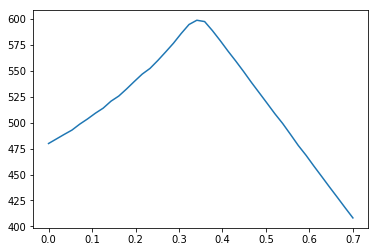

In [6]:
pd.Series(res_dict).plot()

### Смотрим на награду в зависимости от размера скидочного периода 

In [7]:
res_dict = {}
for dics in tqdm(range(12)):
    tmp_list = []
    for i in range(100):
        price,  slsu, on_hand, rew, _ = generateSimpleData(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics, weekMax = weekMax)
        tmp_list.append(np.sum(rew[:]))
    res_dict[dics] = np.mean(tmp_list)

100%|██████████| 12/12 [00:00<00:00, 25.94it/s]


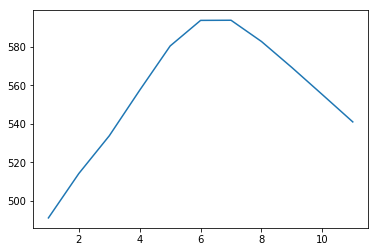

In [8]:
pd.Series(res_dict).rolling(2).mean().plot()

### Точная оценка Q и V

In [9]:
state_cols = ['days_left', 'oh_after']
next_state_cols = [col + '_next' for col in state_cols]

def gen_rl_df(delta, alpha, scale, season, init_oh, disc_len, unit_price =1, weekMax = 12):
    dics = np.random.randint(0, weekMax+1)
    price,  slsu, on_hand, rew, best_est = generateSimpleData(delta, alpha, scale, \
                                                    season, init_oh, disc_len = dics, weekMax = weekMax)

    res_ser = rew*unit_price
    days_left = np.arange(weekMax, 0, -1)-1


    df = pd.concat([pd.Series(price), 
               pd.Series(season),
               pd.Series(on_hand),
               pd.Series(days_left), 
               pd.Series(slsu), 
               pd.Series(res_ser).shift(-1), 
               pd.Series(best_est)], 1)

    
    df.columns = ['price','season', 'on_hand','days_left', 'slsu' , 'rev_ser', 'bst_est']
    df['d_r_sh'] = df.on_hand / df.slsu
    df['oh_after'] = df.on_hand - df.slsu


    df['action'] = (df.price -1. ).fillna(0)

    df_shifted = df[state_cols].shift(-1)
    df_shifted.columns = next_state_cols

    return pd.concat([df[state_cols], df_shifted, df[['action', 'rev_ser', 'slsu', 'bst_est']]], 1)
    


def V(oh_left, reg_sales,disc_sales,delta, days_left  ):
    res_list = [1*min(reg_sales*days_left,oh_left)]
    
    for i in range(days_left):
        reg_price_sales = min(i*reg_sales, oh_left)
        cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
        res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

    return max(res_list)

def Q(oh_left, reg_sales,disc_sales,delta, days_left, action):
    if not days_left:
        return 0
    
    if action >= 0:
        res_list = [1*min(reg_sales*days_left,oh_left)]
        
        for i in range(1, days_left+1):
            reg_price_sales = min(i*reg_sales, oh_left)
            cor_proce_sales = min(disc_sales*(days_left - i),oh_left - reg_price_sales)
            res_list.append(reg_price_sales*1. + cor_proce_sales*(1- delta))

        return  max(res_list)
    
    return (1- delta)*min(disc_sales*days_left,oh_left)


## Обучение RF на точное значение Q

In [10]:

samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'slsu', 'bst_est']]
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

100%|██████████| 1000/1000 [00:17<00:00, 56.99it/s]
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [11]:
from sklearn.ensemble import RandomForestRegressor
r = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
r.fit(df[['oh_after', 'days_left']].values, df.Q_keep.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:

samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'slsu', 'bst_est']]
#df['oh_after'] = df.on_hand - df.slsu
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)
df['predicted'] = r.predict(df[['oh_after', 'days_left']].values)

# Q-learning training

In [12]:

from sklearn.ensemble import RandomForestRegressor
r = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
#r.fit(df[['oh_after', 'days_left']].values, df.Q_keep.values)

In [13]:
samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)

100%|██████████| 1000/1000 [00:15<00:00, 62.73it/s]


In [14]:
for i in tqdm(range(50)):
    if i:
        
        df['pred_0']   = r.predict(df[['days_left_next','oh_after_next', 'dumm_0']])
        df['pred_m35'] = r.predict(df[['days_left_next','oh_after_next', 'dumm_m35']])
        
        df.loc[df.days_left == 0, ['pred_0','pred_m35']] = 0.
        
        df['V_next']   = np.maximum(df['pred_0'], df['pred_m35'])
        df['target']   = df.rev_ser + df['V_next']
    else:
        df['target'] = df.rev_ser
        
    r.fit(df[[ 'days_left','oh_after', 'action']].values, df.target.values)

100%|██████████| 50/50 [12:04<00:00, 15.09s/it]


i = 0

print(i)
if i:
        
    df['pred_0']   = r.predict(df[['days_left_next','oh_after_next', 'dumm_0']])
    df['pred_m35'] = r.predict(df[['days_left_next','oh_after_next', 'dumm_m35']])

    df.loc[df.days_left == 0, ['pred_0','pred_m35']] = 0.

    df['V_next']   = np.maximum(df['pred_0'], df['pred_m35'])
    df['target']   = df.rev_ser + df['V_next']
else:
    df['target'] = df.rev_ser

r.fit(df[[ 'days_left', 'oh_after','action']].values, df.target.values)
i+=1

In [15]:

df

,days_left,oh_after,days_left_next,oh_after_next,action,rev_ser,dumm_0,dumm_m35,V,Q_keep,Q_disc,target,pred_0,pred_m35,V_next
0,11,747.0,10.0,716.0,0.00,31.00,0.0,-0.35,555.5500,555.5500,485.5500,539.664462,505.434653,508.664462,508.664462
1,10,716.0,9.0,684.0,0.00,32.00,0.0,-0.35,521.4000,521.4000,465.4000,501.493356,469.493356,469.456087,469.493356
2,9,684.0,8.0,650.0,0.00,34.00,0.0,-0.35,486.6000,486.6000,444.6000,470.838215,419.169688,436.838215,436.838215
3,8,650.0,7.0,608.0,0.00,42.00,0.0,-0.35,449.2130,449.2130,422.5000,416.591016,374.591016,374.591016,374.591016
4,7,608.0,6.0,564.0,0.00,44.00,0.0,-0.35,409.2000,409.2000,395.2000,377.029014,332.837650,333.029014,333.029014
5,6,564.0,5.0,524.0,0.00,40.00,0.0,-0.35,366.6000,347.6775,366.6000,330.362514,282.911125,290.362514,290.362514
6,5,524.0,4.0,483.0,0.00,41.00,0.0,-0.35,307.6775,286.1420,307.6775,278.491631,227.638597,237.491631,237.491631
7,4,483.0,3.0,381.0,0.00,66.30,0.0,-0.35,246.1420,224.6065,246.1420,250.701084,167.989201,184.401084,184.401084
8,3,381.0,2.0,292.0,-0.35,57.85,0.0,-0.35,184.6065,163.0710,184.6065,180.499171,103.703599,122.649171,122.649171
9,2,292.0,1.0,200.0,-0.35,59.80,0.0,-0.35,123.0710,101.5355,123.0710,123.439427,60.057673,63.639427,63.639427


In [30]:
samples_list = []
for i in tqdm(range(100)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df = data_samples[state_cols + ['rev_ser', 'action']]
df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)



100%|██████████| 100/100 [00:02<00:00, 38.92it/s]/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [31]:
df['dumm_0'] = 0.
df['dumm_m35'] = -.35
df['Q_keep_pred'] = r.predict(df[['days_left','oh_after', 'dumm_0']].values)
df['Q_disc_pred'] = r.predict(df[['days_left','oh_after', 'dumm_m35']].values)

In [35]:
df[ ['days_left', 'oh_after','action','rev_ser' ,'Q_keep', 'Q_disc', 'Q_keep_pred', 'Q_disc_pred'] ]

,days_left,oh_after,action,rev_ser,Q_keep,Q_disc,Q_keep_pred,Q_disc_pred
0,11,758.0,0.00,45.00,562.7000,492.7000,542.629041,542.629041
1,10,713.0,0.00,36.00,519.4500,463.4500,501.635883,496.461832
2,9,677.0,0.00,39.00,482.0500,440.0500,464.101602,461.924263
3,8,638.0,0.00,47.00,442.7000,414.7000,428.238578,425.857655
4,7,591.0,0.00,36.00,398.1500,384.1500,394.841662,391.606214
5,6,555.0,0.00,68.25,347.6775,360.7500,347.135836,354.201497
6,5,450.0,-0.35,63.70,286.1420,292.5000,292.853149,292.901190
7,4,352.0,-0.35,65.65,224.6065,228.8000,229.383298,229.627727
8,3,251.0,-0.35,63.05,163.0710,163.1500,164.211910,163.079445
9,2,154.0,-0.35,61.75,101.5355,100.1000,102.541737,100.072709


### Явное обучние нейронной сети

df.to_pickle('df.pickle')

In [13]:
import pickle
df = pickle.load(open('df.pickle', 'rb'))
df = df.iloc[:1200, :]


X_train = df[['oh_after', 'days_left']].values
labels_train = df[['Q_keep', 'Q_disc']].values

### Tensofflow попытка

In [ ]:
import numpy as np
import pandas as pd        # For loading and processing the dataset
import tensorflow as tf    # Of course, we need TensorFlow.
from sklearn.model_selection import train_test_split

In [16]:
inputs = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]), name='inputs')
outputs = tf.placeholder(tf.float32, shape=(None, 2), name='outputs')

In [17]:
#inputs = tf.placeholder(tf.float32, shape=(None, X_train.shape[1]), name='inputs')
#label = tf.placeholder(tf.float32, shape=(None, 2), name='labels')

# First layer
hid1_size = 16
w1 = tf.Variable(tf.random_normal([hid1_size, X_train.shape[1]], stddev=0.01), name='w1')
b1 = tf.Variable(tf.constant(0.1, shape=(hid1_size, 1)), name='b1')
y1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(w1, tf.transpose(inputs)), b1)), keep_prob=0.5)



In [18]:
# Second layer
hid2_size = 32
w2 = tf.Variable(tf.random_normal([hid2_size, hid1_size], stddev=0.01), name='w2')
b2 = tf.Variable(tf.constant(0.1, shape=(hid2_size, 1)), name='b2')
y2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(w2, y1), b2)), keep_prob=0.5)



In [19]:
# Output layer
wo = tf.Variable(tf.random_normal([2, hid2_size], stddev=0.01), name='wo')
bo = tf.Variable(tf.random_normal([2, 1]), name='bo')
yo = tf.transpose(tf.add(tf.matmul(wo, y2), bo))

tf.losses.mean_squared_error(
    labels,
    predictions,
)

In [20]:
# Loss function and optimizer
lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')
loss = tf.reduce_mean(tf.losses.mean_squared_error(predictions=yo, labels=outputs))
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)



### Prediction
pred = tf.nn.softmax(yo)
pred_label = tf.argmax(pred, 1)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

### Prediction
pred = tf.nn.softmax(yo)
pred_label = tf.argmax(pred, 1)
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [21]:
# Create operation which will initialize all variables
init = tf.global_variables_initializer()

# Configure GPU not to use all memory
config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

# Start a new tensorflow session and initialize variables
sess = tf.InteractiveSession(config=config)
sess.run(init)

/Volumes/C/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
# This is the main training loop: we train for 50 epochs with a learning rate of 0.05 and another 
# 50 epochs with a smaller learning rate of 0.01
for learning_rate in [0.05, 0.01]:
    for epoch in range(50):
        avg_cost = 0.0

        # For each epoch, we go through all the samples we have.
        for i in range(X_train.shape[0]):
            # Finally, this is where the magic happens: run our optimizer, feed the current example into X and the current target into Y
            _, c = sess.run([optimizer, loss], feed_dict={lr:learning_rate, 
                                                          inputs: X_train[i, None],
                                                          outputs: labels_train[i, None]})
            avg_cost += c
        avg_cost /= X_train.shape[0]    

        # Print the cost in this epcho to the console.
        if epoch % 10 == 0:
            print("Epoch: {:3d}    Train Cost: {:.4f}".format(epoch, avg_cost))

# Keras попытка

In [38]:
import pickle
df = pickle.load(open('df.pickle', 'rb'))
#df = df.iloc[:1200, :]




In [92]:
samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)




 72%|███████▏  | 716/1000 [00:19<00:07, 39.26it/s]


100%|██████████| 1000/1000 [00:25<00:00, 39.54it/s]

In [240]:
X_train = df[['oh_after', 'days_left']].values
labels_train = df[['Q_keep']].values

In [190]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import SGD, RMSprop,Adagrad

In [214]:
# define the architecture of the network
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], init="uniform", activation="relu"))
model.add(Dropout(0.2))
#model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
#model.add(Dropout(0.5))
#model.add(Dense(128, activation="relu", kernel_initializer="uniform"))
#model.add(Dropout(0.5))
model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
model.add(Dense(labels_train.shape[1]))
model.compile(Adagrad(), 'MSE')



/Volumes/C/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, input_dim=2, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [215]:
from tqdm import tqdm 

In [ ]:
err_list = []
for i in tqdm(range(50000),mininterval=10 ):
    idx = np.random.randint(X_train.shape[0], size = 5000)
    err = model.train_on_batch(X_train[idx], labels_train[idx])
    err_list.append(err)
    if i %500 ==0 :
        print(err)













  0%|          | 0/50000 [00:00<?, ?it/s]

480.8535














  1%|          | 283/50000 [00:10<29:18, 28.27it/s]

476.69626














  1%|          | 566/50000 [00:20<29:21, 28.06it/s]











  2%|▏         | 842/50000 [00:30<29:28, 27.80it/s]

525.93335














  2%|▏         | 1174/50000 [00:40<27:51, 29.22it/s]











  3%|▎         | 1506/50000 [00:53<28:44, 28.12it/s]

525.3523














  4%|▎         | 1827/50000 [01:03<27:29, 29.20it/s]

508.7743














  4%|▍         | 2150/50000 [01:13<26:32, 30.05it/s]











  5%|▍         | 2474/50000 [01:23<25:47, 30.71it/s]

482.4591














  6%|▌         | 2798/50000 [01:33<25:16, 31.12it/s]

490.2456














  6%|▌         | 3120/50000 [01:43<24:51, 31.43it/s]











  7%|▋         | 3442/50000 [01:54<25:19, 30.65it/s]

436.5655














  8%|▊         | 3785/50000 [02:04<24:20, 31.64it/s]

523.57745














  8%|▊         | 4129/50000 [02:14<23:35, 32.42it/s]











  9%|▉         | 4475/50000 [02:24<22:58, 33.03it/s]

465.42596














 10%|▉         | 4821/50000 [02:34<22:41, 33.17it/s]

485.08624














 10%|▉         | 4821/50000 [02:45<22:41, 33.17it/s]











 10%|█         | 5144/50000 [02:45<23:04, 32.40it/s]











 11%|█         | 5487/50000 [02:55<22:32, 32.92it/s]

500.74454














 12%|█▏        | 5830/50000 [03:05<22:14, 33.09it/s]

531.4438














 12%|█▏        | 6165/50000 [03:18<23:56, 30.52it/s]











 13%|█▎        | 6424/50000 [03:30<26:23, 27.52it/s]

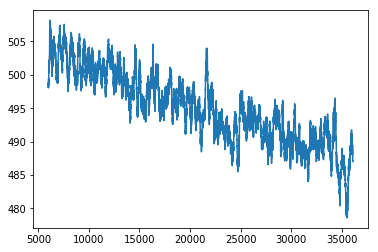












 72%|███████▏  | 36056/50000 [18:43<07:39, 30.37it/s]

In [236]:
pd.Series(err_list).rolling(200).mean().iloc[6000:].plot()

In [237]:
samples_list = []
for i in tqdm(range(1000)):
    tmp_df = gen_rl_df(delta = .35, alpha = 2., scale = 40, season = season, init_oh = init_oh, disc_len = dics)
    samples_list.append(tmp_df)
    
data_samples = pd.concat(samples_list)



df =data_samples[['days_left', 'oh_after', 'days_left_next', 'oh_after_next', 'action', 'rev_ser']].fillna(0)
df['dumm_0'] = 0.
df['dumm_m35'] = -.35

df['V'] = df.apply(lambda x:V(x['oh_after'], 40, 94.67, .35, int(x['days_left'])), 1)
df['Q_keep'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), 0), 1)
df['Q_disc'] = df.apply(lambda x:Q(x['oh_after'], 40, 94.67, .35, int(x['days_left']), -.35), 1)













  0%|          | 0/1000 [00:00<?, ?it/s]











  1%|          | 6/1000 [00:00<00:20, 48.88it/s]











  1%|          | 12/1000 [00:00<00:19, 50.49it/s]











  2%|▏         | 15/1000 [00:00<00:23, 41.60it/s]











  2%|▏         | 19/1000 [00:00<00:24, 39.80it/s]











  2%|▎         | 25/1000 [00:00<00:22, 43.33it/s]











  3%|▎         | 30/1000 [00:00<00:22, 43.07it/s]











  4%|▎         | 35/1000 [00:00<00:22, 43.51it/s]











  4%|▍         | 41/1000 [00:00<00:20, 46.60it/s]











  5%|▍         | 46/1000 [00:01<00:21, 44.80it/s]











  5%|▌         | 51/1000 [00:01<00:20, 45.72it/s]











  6%|▌         | 56/1000 [00:01<00:26, 36.13it/s]











  6%|▌         | 60/1000 [00:01<00:29, 32.17it/s]











  6%|▋         | 64/1000 [00:01<00:27, 33.61it/s]











  7%|▋         | 68/1000 [00:01<00:26, 34.59it/s]











  7%|▋         | 72/1000 [00:01<00:26, 35.01it/s]











  8%|▊         | 76/10

 43%|████▎     | 431/1000 [00:11<00:10, 52.21it/s]











 44%|████▎     | 437/1000 [00:11<00:10, 53.61it/s]











 44%|████▍     | 443/1000 [00:11<00:10, 54.85it/s]











 45%|████▍     | 449/1000 [00:11<00:10, 53.81it/s]











 46%|████▌     | 455/1000 [00:12<00:10, 52.67it/s]











 46%|████▌     | 462/1000 [00:12<00:09, 56.33it/s]











 47%|████▋     | 468/1000 [00:12<00:09, 55.94it/s]











 48%|████▊     | 475/1000 [00:12<00:09, 58.29it/s]











 48%|████▊     | 481/1000 [00:12<00:09, 55.66it/s]











 49%|████▊     | 487/1000 [00:12<00:09, 54.18it/s]











 49%|████▉     | 494/1000 [00:12<00:08, 56.85it/s]











 50%|█████     | 500/1000 [00:12<00:08, 57.50it/s]











 51%|█████     | 507/1000 [00:12<00:08, 60.24it/s]











 51%|█████▏    | 514/1000 [00:13<00:07, 60.81it/s]











 52%|█████▏    | 521/1000 [00:13<00:07, 61.75it/s]











 53%|█████▎    | 529/1000 [00:13<00:07, 64.48it/s]











 54%|███

 98%|█████████▊| 975/1000 [00:21<00:00, 56.14it/s]











 98%|█████████▊| 981/1000 [00:21<00:00, 56.57it/s]











 99%|█████████▊| 987/1000 [00:21<00:00, 56.98it/s]











 99%|█████████▉| 993/1000 [00:21<00:00, 52.68it/s]











100%|██████████| 1000/1000 [00:21<00:00, 55.70it/s]













In [238]:
#pred_df = pd.DataFrame(model.predict(df[['oh_after', 'days_left']]), columns=  ['q_keep_pred', 'q_disc_pred'])
pred_df = pd.DataFrame(model.predict(df[['oh_after', 'days_left']]), columns=  ['q_keep_pred'])

df['q_keep_pred'] = pred_df['q_keep_pred']
#df['q_disc_pred'] = pred_df['q_disc_pred']

df[df.q_keep_pred < df.q_disc_pred]

In [239]:
#df[ ['days_left', 'oh_after','action','rev_ser' ,'Q_keep', 'Q_disc', 'q_keep_pred', 'q_disc_pred'] ]
df[ ['days_left', 'oh_after','action','rev_ser' ,'Q_keep',  'q_keep_pred'] ]

,days_left,oh_after,action,rev_ser,Q_keep,q_keep_pred
0,11,759.0,0.00,47.00,563.3500,458.279480
1,10,712.0,0.00,38.00,518.8000,421.759277
2,9,674.0,0.00,46.00,480.1000,387.053955
3,8,628.0,0.00,49.00,436.2000,350.735443
4,7,579.0,0.00,43.00,390.3500,313.811859
5,6,536.0,0.00,63.70,347.6775,278.098297
6,5,438.0,-0.35,58.50,286.1420,230.244385
7,4,348.0,-0.35,66.95,224.6065,178.913696
8,3,245.0,-0.35,61.75,163.0710,126.059578
9,2,150.0,-0.35,52.00,101.5355,74.490799


# Тут разная чушь, не имеющая значения

In [ ]:
import os
from random import sample as rsample

import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import SGD, RMSprop

from matplotlib import pyplot as plt


GRID_SIZE = 10


nb_epochs = 1000
batch_size = 128
epsilon = .8
gamma = .8

# Recipe of deep reinforcement learning model
model = Sequential()
model.add(Convolution2D(16, nb_row=3, nb_col=3, input_shape=(1, GRID_SIZE, GRID_SIZE), activation='relu'))
model.add(Convolution2D(16, nb_row=3, nb_col=3, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3))
model.compile(RMSprop(), 'MSE')

exp_replay = experience_replay(batch_size)
exp_replay.next()  # Start experience-replay coroutine

for i in xrange(nb_epochs):
    ep = episode()
    S, won = ep.next()  # Start coroutine of single entire episode
    loss = 0.
    try:
        while True:
            action = np.random.randint(-1, 2) 
            if np.random.random() > epsilon:
                # Get the index of the maximum q-value of the model.
                # Subtract one because actions are either -1, 0, or 1
                action = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1

            S_prime, won = ep.send(action)
            experience = (S, action, won, S_prime)
            S = S_prime
            
            batch = exp_replay.send(experience)
            if batch:
                inputs = []
                targets = []
                for s, a, r, s_prime in batch:
                    # The targets of unchosen actions are the q-values of the model,
                    # so that the corresponding errors are 0. The targets of chosen actions
                    # are either the rewards, in case a terminal state has been reached, 
                    # or future discounted q-values, in case episodes are still running.
                    t = model.predict(s[np.newaxis]).flatten()
                    t[a + 1] = r
                    if not r:
                        t[a + 1] = r + gamma * model.predict(s_prime[np.newaxis]).max(axis=-1)
                    targets.append(t)
                    inputs.append(s)
                
                loss += model.train_on_batch(np.array(inputs), np.array(targets))[0]

    except StopIteration:
        pass
    
    if (i + 1) % 100 == 0:
        print 'Epoch %i, loss: %.6f' % (i + 1, loss)


def save_img():
    if 'images' not in os.listdir('.'):
        os.mkdir('images')
    frame = 0
    while True:
        screen = (yield)
        plt.imshow(screen[0], interpolation='none')
        plt.savefig('images/%03i.png' % frame)
        frame += 1
    
img_saver = save_img()
img_saver.next()

for _ in xrange(10):
    g = episode()
    S, _ = g.next()
    img_saver.send(S)
    try:
        while True:
            act = np.argmax(model.predict(S[np.newaxis]), axis=-1)[0] - 1
            S, _ = g.send(act)
            img_saver.send(S)

    except StopIteration:
        pass

img_saver.close()

In [ ]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [ ]:
init = tf.initialize_all_variables()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"